In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import firebase_admin
from firebase_admin import firestore

In [2]:
cred = firebase_admin.credentials.Certificate('./gramjam-7b408-firebase-adminsdk-z4za6-90b0b4291e.json')
app = firebase_admin.initialize_app(cred)

<AxesSubplot:>

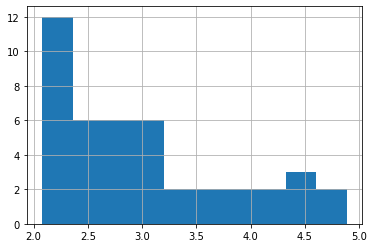

In [29]:
%matplotlib inline

db = firestore.client()

analytics = db.collection('analytics')

docs = analytics.stream()
df = pd.DataFrame(d.to_dict() for d in docs)
df['turns'][df['turns'] > 0].map(math.log).hist()


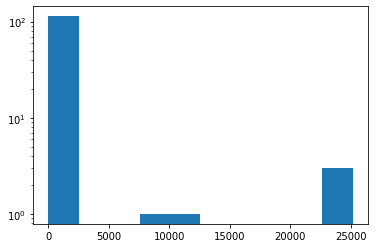

In [24]:
plt.hist(df['duration'], log=True)
plt.show()

In [31]:
feedback = db.collection('feedback')
for doc in feedback.stream():
    print(doc.to_dict())

{'userId': 'd622c4b9-3faf-4461-ba97-ad5f8c045c94', 'feedback': 'OMG I love your game!', 'date': DatetimeWithNanoseconds(2022, 4, 24, 1, 40, 39, 408000, tzinfo=datetime.timezone.utc)}
